# Домашнє завдання: LSTM для прогнозування часових рядів

Давайте подивимося, як LSTM можна використовувати для побудови нейронної мережі прогнозування часових.

Будемо працювати з задачею прогнозування кількості пасажирів міжнародних авіаліній. З цим набором даних ми вже працювали в лекції "Time Series Analysis" і ви зможете порівняти результати :)

Задача полягає в тому, щоб за заданими роком і місяцем передбачити кількість пасажирів міжнародних авіаліній в одиницях виміру 1,000. Дані охоплюють період з січня 1949 року по грудень 1960 року, тобто 12 років, зі 144 спостереженнями.

Це регресійна задача. Тобто, знаючи кількість пасажирів (в тисячах) за останні місяці, можна передбачити, якою буде кількість пасажирів у наступному місяці. Набір даних має лише одну характеристику: "Кількість пасажирів" - `Passengers`.

Далі вже наведений код для читання даних, але нам їх ще треба буде трошки обробити.

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [3]:
# Завантаження даних
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
df = pd.read_csv(url)
df.set_index('Month', inplace=True)
display(df.head())

,Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


**Завдання 1.** Створіть змінну типу `numpy.ndarray`, яка містить значення кількості пасажирів в форматі `float32`. Такий формат даних нам треба для тренування нейромережі.

In [4]:
passenger_values = np.array(df['Passengers'].values, dtype=np.float32)
passenger_values

array([112., 118., 132., 129., 121., 135., 148., 148., 136., 119., 104.,
       118., 115., 126., 141., 135., 125., 149., 170., 170., 158., 133.,
       114., 140., 145., 150., 178., 163., 172., 178., 199., 199., 184.,
       162., 146., 166., 171., 180., 193., 181., 183., 218., 230., 242.,
       209., 191., 172., 194., 196., 196., 236., 235., 229., 243., 264.,
       272., 237., 211., 180., 201., 204., 188., 235., 227., 234., 264.,
       302., 293., 259., 229., 203., 229., 242., 233., 267., 269., 270.,
       315., 364., 347., 312., 274., 237., 278., 284., 277., 317., 313.,
       318., 374., 413., 405., 355., 306., 271., 306., 315., 301., 356.,
       348., 355., 422., 465., 467., 404., 347., 305., 336., 340., 318.,
       362., 348., 363., 435., 491., 505., 404., 359., 310., 337., 360.,
       342., 406., 396., 420., 472., 548., 559., 463., 407., 362., 405.,
       417., 391., 419., 461., 472., 535., 622., 606., 508., 461., 390.,
       432.], dtype=float32)

Очікуваний результат:
```array([112., 118., 132., 129., 121.], dtype=float32)```

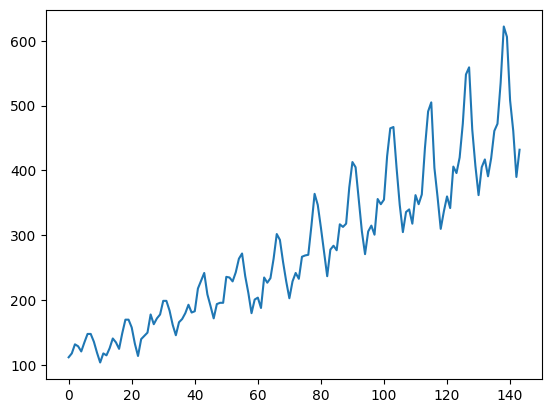

In [5]:
plt.plot(passenger_values)
plt.show()

**Завдання 2**. Розбийте дані на тренувальні і валідаційні у
співвідношенні 67% йде у тренування, 33 - у валідацію. Памʼятаємо, що ми працюємо з tim series, відповідно, навчаємось на давніших, валідуємось - на новіших.

In [6]:
train_size = int(len(passenger_values) * 0.67)

train = passenger_values[:train_size]
test = passenger_values[train_size:]

**Завдання 3**.

Реалізуйте функцію `create_dataset`, яка перетворить одномірний часовий ряд (набір даних) у формат, придатний для тренування нейромережі.

Функція повинна приймати два аргументи:
- `dataset` — numpy-масив часового ряду,
- `lookback` — кількість попередніх кроків, які використовуватимуться для передбачення.

Функція повинна повернути два **тензори** PyTorch:
- `X` — набір ознак (вікно попередніх значень),
- `y` — цільові значення (наступні після вікна кроки).

Дані ми будемо подавати моделі в наступному форматі:
`
tensor([[112.],
        [118.],
        [132.],
        [129.],
        [121.]])
`
Відповідно першою розмірністю буде йти розмір вхідного батча, а другою - розмір вхіднизх даних і в нас це 1, бо лише одне значення на вході щоразу.

Після виконання завдання запустіть код нижче. Ми будемо передбачати на основі кількості пасажирів в попередній день кількість пасажирів в наступний, тому `lookback == 1`.

In [7]:
def create_dataset(dataset, lookback=1):
    X, y = [], []
    for i in range(len(dataset) - 1):
        X.append(dataset[i:i+lookback])
        y.append(dataset[i+1:i+lookback+1])

    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32)

    return X, y

In [8]:
X_train, y_train = create_dataset(train)
X_test, y_test = create_dataset(test)

In [9]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([95, 1]) torch.Size([95, 1])
torch.Size([47, 1]) torch.Size([47, 1])


Очікуваний результат:
```
torch.Size([95, 1]) torch.Size([95, 1])
torch.Size([47, 1]) torch.Size([47, 1])
```

**Завдання 4**.

Зверніть увагу на розмірності в попередньому завданні. Ми
З допомогою модуля `torch.nn` опишіть клас `AirModel`, який є нейронною мережею для прогнозування кількості пасажирів за допомогою LSTM.

1. **Конструктор класу** повинен приймати параметри `hidden_size`, `num_layers` та ініціювати шари:
   - LSTM-шар з наступними параметрами:
     - `input_size` — кожна точка часового ряду є окремим входом,,
     - `hidden_size` — заданий в конструкторі класу мережі,
     - `num_layers=1` — кількість шарів LSTM, задана в конструкторі мережі,
     - `batch_first=True` — визначає, що першим виміром є розмір батчу.
   - Лінійний шар (`nn.Linear`) для перетворення виходу LSTM на прогноз однієї точки.

2. **Метод forward** повинен виконувати наступні дії:
   - Передати вхідний тензор через LSTM-шар і отримати виходи (ігноруючи приховані стани).
   - Пропустити вихід LSTM через лінійний шар для отримання остаточного прогнозу.

Створіть об'єкт класу `AirModel` зі значеннями параметрів `hidden_size=50`, `num_layers=1` і протестуйте роботу моделі на вхідному тензорі `tensor([[112.]])`. На цьому етапі ми маємо переконатись, що модель здатна генерувати передбачення з рандомно ініційованими вагами.

In [10]:
class AirModel(nn.Module):
  def __init__(self, hidden_size, num_layers) -> None:
     super(AirModel, self).__init__()

     self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
     self.linear = nn.Linear(hidden_size, 1)

  def forward(self, x):
    lstm_output, _ = self.lstm(x)
    output = self.linear(lstm_output)
    return output

In [11]:
model = AirModel(hidden_size=50, num_layers=1)

In [12]:
test_input = torch.tensor([[112.]], dtype=torch.float32).unsqueeze(0)

In [13]:
output = model(test_input)
output

tensor([[[-0.1341]]], grad_fn=<ViewBackward0>)

**Завдання 5**.

Створіть об'єкт DataLoader для завантаження даних, використовуючи тренувальні вибірки `X_train` та `y_train`. Ваш DataLoader повинен виконувати наступні вимоги:

1. Використовувати клас `TensorDataset`, щоб об'єднати тензори ознак `X_train` і цільових значень `y_train`.
2. Дані повинні завантажуватися невеликими батчами розміром 8 за допомогою параметра `batch_size`.
3. Використовувати параметр `shuffle=True`, щоб дані перемішувалися перед кожною епохою тренування.


In [14]:
loader = DataLoader(TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

**Завдання 6**.

1. Реалізуйте навчання нейронної мережі `AirModel` для прогнозування часових рядів, використовуючи Adam-оптимізатор та функцію втрат MSE (середньоквадратичну похибку).
2. Створіть цикл тренування для 2000 епох, у якому на кожній епосі:
   - Виконуйте крок тренування моделі (прямий прохід, обчислення похибки, зворотний прохід і оновлення ваг).
   - Підраховуйте середню похибку на кожному батчі даних і зберігайте її у списку `losses`.
3. Раз на 100 епох проводьте валідацію моделі:
   - Перевіряйте модель на тренувальних та тестових даних без оновлення ваг.
   - Обчислюйте корінь середньоквадратичної похибки (RMSE) для тренувальної та тестової вибірок і виводьте результати на екран.
   
**Примітка:**
- Використовуйте вже створений `DataLoader` для отримання батчів даних.
- Валідацію виконуйте в режимі `eval()`, вимикаючи обчислення градієнтів з `torch.no_grad()`.

**Приклад виходу:**
```
Epoch 0: train RMSE 12.3456, test RMSE 15.6789
Epoch 100: train RMSE 9.8765, test RMSE 12.3456
...
```

In [15]:
def calculate_rmse(criterion, predictions, targets):
    mse = criterion(predictions, targets)
    rmse = torch.sqrt(mse)
    return rmse

In [16]:
model = AirModel(hidden_size=50, num_layers=1)

lookback = 1
num_epochs = 2000
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [17]:
def train_and_validate(model, loader, optimizer, criterion, X_train, y_train, X_test, y_test, n_epochs=2000, print_interval=100):
    train_losses = []
    test_losses = []

    for epoch in range(n_epochs):
        model.train()
        for X_batch, y_batch in loader:
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if epoch % print_interval != 0:
            continue
        model.eval()
        with torch.no_grad():
            y_pred_train = model(X_train)
            train_mse = criterion(y_pred_train, y_train)
            train_rmse = torch.sqrt(train_mse)
            train_losses.append(train_rmse)

            y_pred_test = model(X_test)
            test_mse = criterion(y_pred_test, y_test)
            test_rmse = torch.sqrt(test_mse)
            test_losses.append(test_rmse)

        print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

    return train_losses, test_losses

In [18]:
train_losses, test_losses = train_and_validate(model, loader, optimizer, criterion, X_train, y_train, X_test, y_test)

Epoch 0: train RMSE 225.3008, test RMSE 421.5965
Epoch 100: train RMSE 174.4877, test RMSE 368.4472
Epoch 200: train RMSE 135.6714, test RMSE 325.9020
Epoch 300: train RMSE 104.5115, test RMSE 288.4160
Epoch 400: train RMSE 83.0723, test RMSE 256.5744
Epoch 500: train RMSE 64.4417, test RMSE 228.9893
Epoch 600: train RMSE 47.4099, test RMSE 195.9578
Epoch 700: train RMSE 37.1372, test RMSE 170.1496
Epoch 800: train RMSE 30.9450, test RMSE 149.9440
Epoch 900: train RMSE 27.2249, test RMSE 132.6334
Epoch 1000: train RMSE 26.0503, test RMSE 119.6187
Epoch 1100: train RMSE 24.4051, test RMSE 113.0940
Epoch 1200: train RMSE 23.5229, test RMSE 104.4167
Epoch 1300: train RMSE 24.5253, test RMSE 105.7067
Epoch 1400: train RMSE 23.3488, test RMSE 97.7166
Epoch 1500: train RMSE 23.6213, test RMSE 96.3273
Epoch 1600: train RMSE 23.2800, test RMSE 91.8984
Epoch 1700: train RMSE 23.9851, test RMSE 92.3252
Epoch 1800: train RMSE 22.7915, test RMSE 85.1494
Epoch 1900: train RMSE 22.5582, test RMSE 91

**Завдання 7.** Побудуйте графік лосів. Зробіть висновок з графіку, чи навчилась модель?

In [19]:
import matplotlib.pyplot as plt

def plot_losses(train_losses, test_losses):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    ax[0].plot(train_losses, label='Train Loss', color='blue')
    ax[0].set_xlabel("Епоха")
    ax[0].set_ylabel("Значення функції втрат")
    ax[0].set_title("Зменшення функції втрат для тренувальної вибірки")
    ax[0].legend()
    ax[0].grid(True)

    ax[1].plot(test_losses, label='Test Loss', color='red')
    ax[1].set_xlabel("Епоха")
    ax[1].set_ylabel("Значення функції втрат")
    ax[1].set_title("Зменшення функції втрат для тестової вибірки")
    ax[1].legend()
    ax[1].grid(True)

    plt.tight_layout()
    plt.show()

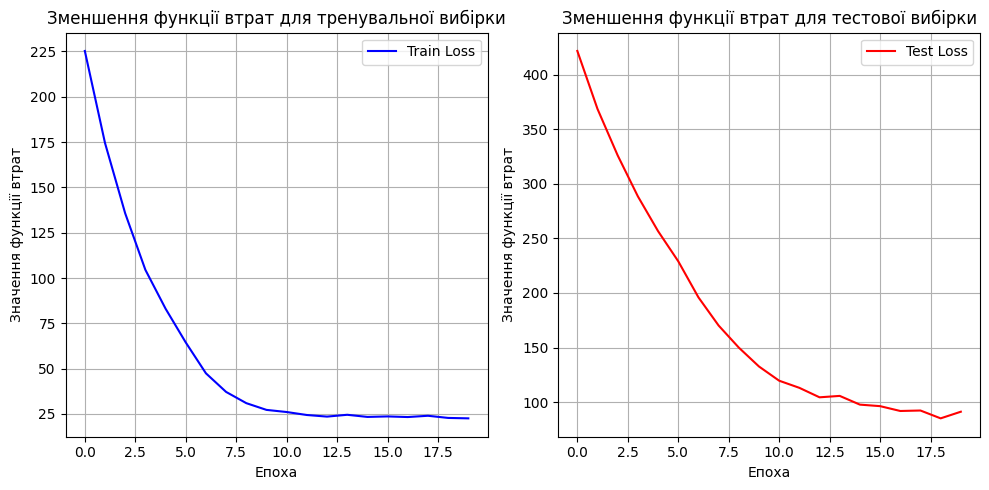

In [20]:
plot_losses(train_losses, test_losses)

**Спостереження**:

- Можемо бачити стабільне зменшення втрат на обох графіках. Значення функції втрат у тренувальній вибірці зменшуються різко до епохи 1000, після чого майже стабілізуються. У тестовій вибірці спостерігається аналогічна тенденція — значення втрат поступово зменшується, хоча й має невеликі коливання після 1000-ї епохи.
- Криві мають подібну форму. Може говорити, що модель має можливість узагальнювати.


Отже, в цілому модель демонструє стабільне зменшення втрат на обох вибірках, без явних ознак перенавчання, але значення RMSE на тренувальній вибірці зменшується стабільно від 225 до 22. коли RMSE на тестовій вибірці також знижується: від 422 до 84.

Модель навчилась, але не факт, що точно)

Доволі неочікувано, що середньоквадратичне відхилення тестового набору даних буде на порядок більшим за одиниці в нашому наборі даних. Середньоквадратичне відхилення 100 означає, що прогноз і фактичне значення будуть відрізнятися в середньому на 100 (тобто, 100 000 пасажирів у цьому наборі даних).



Щоб краще зрозуміти якість прогнозу, ви можете побудувати графік з кодом нижче (а ще нижче - описано, що відбувається в цьому коді, бо це теж корисно зрозуміти):

In [21]:
timeseries = passenger_values

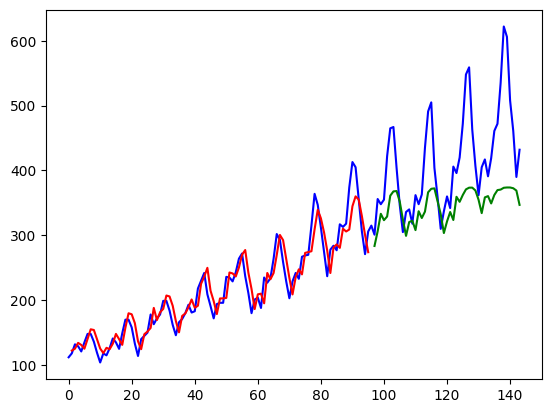

In [22]:
def plot_predicts(model):
  with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=DeprecationWarning)
        with torch.no_grad():
            # Зсув прогнозів для тренувальних даних
            train_plot = np.ones_like(timeseries) * np.nan
            y_pred = model(X_train)
            y_pred = y_pred[:, -1]
            train_plot[lookback:train_size] = model(X_train)[:, -1]

            # Зсув прогнозів для тестових даних
            test_plot = np.ones_like(timeseries) * np.nan
            test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1]

  # Візуалізація результатів
  plt.plot(timeseries, c='b')  # Реальні дані
  plt.plot(train_plot, c='r')  # Прогнози на тренувальних даних
  plt.plot(test_plot, c='g')   # Прогнози на тестових даних
  plt.show()

plot_predicts(model)

**Що відбувається в коді вище.** В цьому коді здійснюється процес прогнозування часових рядів за допомогою LSTM моделі, а також виведення графіку, який показує реальні значення, тренувальні та тестові прогнози. Ось що відбувається на кожному етапі:

1. **`torch.no_grad()`**: Цей контекстний менеджер вимикає обчислення градієнтів, що означає, що під час прогнозування не будуть зберігатися проміжні обчислення для зворотного проходу (backpropagation). Це підвищує ефективність під час прогнозування і зменшує використання пам'яті.

2. **Зсув прогнозів для тренувальних даних:**
   - Створюється масив `train_plot`, який має такий самий розмір, як і часовий ряд (`timeseries`), і заповнюється значеннями NaN (`np.nan`), щоб залишити місце для реальних значень.
   - Модель передбачає виходи для тренувальних даних `X_train`.
   - Використовується лише останнє передбачене значення для кожного входу LSTM (`y_pred[:, -1]`).
   - Прогнози зсуваються, починаючи з індексу `lookback` до кінця тренувальних даних (індекс `train_size`). Цей зсув потрібен, щоб зробити прогноз на основі попередніх даних і відобразити його на правильній частині графіку.

3. **Зсув прогнозів для тестових даних:**
   - Створюється масив `test_plot`, який також заповнюється NaN.
   - Прогнози для тестових даних додаються з індексу `train_size + lookback` до кінця реальних даних, щоб відобразити, де модель починає прогнозувати тестову вибірку.

4. **Побудова графіка:**
   - `plt.plot(timeseries, c='b')`: Виводить реальні значення часового ряду (синя лінія).
   - `plt.plot(train_plot, c='r')`: Виводить тренувальні прогнози (червона лінія).
   - `plt.plot(test_plot, c='g')`: Виводить тестові прогнози (зелена лінія).

**Чому це робиться:**
- Зсув прогнозів для тренувальних і тестових даних дозволяє візуально зрівняти, наскільки добре модель прогнозує як на тренувальній, так і на тестовій вибірках. Зазвичай, червона лінія (тренувальні прогнози) повинна точно відповідати синій лінії (реальні дані), а зелена лінія (тестові прогнози) дає змогу побачити, наскільки модель добре працює на нових даних, яких вона раніше не бачила.

**Завдання 8**. Навчіть модель з hidden_size=100 та порівняйте результати прогнозів з попередніми.

In [23]:
hidden_size = 100
num_layers = 2
n_epochs = 2000
input_size = 1

model_100 = AirModel(hidden_size=hidden_size, num_layers=num_layers)

optimizer = optim.Adam(model_100.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [24]:
train_losses, test_losses = train_and_validate(model_100, loader, optimizer, criterion, X_train, y_train, X_test, y_test, n_epochs)

Epoch 0: train RMSE 224.1680, test RMSE 420.6771
Epoch 100: train RMSE 123.6266, test RMSE 311.9854
Epoch 200: train RMSE 77.9094, test RMSE 246.3237
Epoch 300: train RMSE 70.5174, test RMSE 216.4746
Epoch 400: train RMSE 70.6792, test RMSE 210.3872
Epoch 500: train RMSE 44.0015, test RMSE 188.8114
Epoch 600: train RMSE 32.0743, test RMSE 149.5117
Epoch 700: train RMSE 28.5141, test RMSE 133.0002
Epoch 800: train RMSE 23.9396, test RMSE 112.2984
Epoch 900: train RMSE 23.3434, test RMSE 100.3206
Epoch 1000: train RMSE 22.8872, test RMSE 87.9542
Epoch 1100: train RMSE 22.3215, test RMSE 82.9750
Epoch 1200: train RMSE 22.8323, test RMSE 83.5602
Epoch 1300: train RMSE 22.2543, test RMSE 80.6735
Epoch 1400: train RMSE 22.3860, test RMSE 81.8889
Epoch 1500: train RMSE 22.6348, test RMSE 83.7317
Epoch 1600: train RMSE 22.8483, test RMSE 87.1210
Epoch 1700: train RMSE 21.9896, test RMSE 79.1383
Epoch 1800: train RMSE 22.9978, test RMSE 84.0877
Epoch 1900: train RMSE 21.8628, test RMSE 83.3801


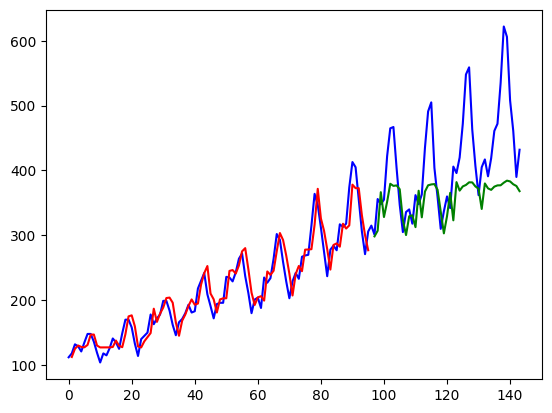

In [25]:
plot_predicts(model_100)

**Спостереження**:

`hidden_size=50`:

- Бачимо, що червона крива дуже точно повторює синю - отже модель добре передбачає на тренувальному інтервалі, і гарно вловлює на тренувальній вибірці як тренд, так і сезонність.

- Зелена крива схожа на синю, але зі значною втратою амплітуди, але загальна форма збережена.

- В цілому модель вивчила патерни часового ряду, і гарно їх відтворює на тренувальних даних, але не дуже гарно узагальнює.

`hidden_size=100`:

- Можемо знову сказати, що червона крива дуже точно повторює синю - отже модель добре передбачає на тренувальному інтервалі.

- Візуально здається, що зелена лінія, не зважаючи на амплітуду, краще відтворює форму. Але, все ж таки, зелена лінія більш згладжена і не відтворює піки з такою ж амплітудою, як реальні значення.


Можемо зробити **загальний висновок**, що зі збільшенням hidden_size до 100 модель стала трошки краще узагальнювати, але все ж таки не почала відтворювати амплітуду, що може свідчити про перенавчання - модель добре запам'ятала тренувальні дані, але не навчилась добре узагальнювати.

